In [1]:
import os
import urllib
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
import time

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)
print(tf.test.gpu_device_name())

2.7.0



In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

#Working with CPU for now...

Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Reading data

In [3]:
# Load the datasets in UCI
def load_UCI(dset_name, splits=10, seed=0, separate_targets=True, save_dir='data/'):
    mkdir(save_dir)

    if dset_name == 'wine':
        if not os.path.isfile(save_dir+'winequality-red.csv'):
            urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                               filename=save_dir+'winequality-red.csv')
        data = pd.read_csv(save_dir+'winequality-red.csv', header=1, delimiter=';').values
        y_idx = [-1]

    elif dset_name == 'default_credit':
        if not os.path.isfile(save_dir + 'default of credit card clients.xls'):
            urllib.request.urlretrieve(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                filename=save_dir + 'default of credit card clients.xls')
        data = pd.read_excel(save_dir + 'default of credit card clients.xls', header=[0, 1], index_col=0, # delimiter="\s+"
                             ).values
        y_idx = [-1]  # OK


    else:
        raise Exception('Dataset name doesnt match any known datasets.')

    np.random.seed(seed)
    data = data[np.random.permutation(np.arange(len(data)))]

    kf = KFold(n_splits=splits)
    for j, (train_index, test_index) in enumerate(kf.split(data)):

        # Not sure what separate targets is
        if separate_targets:
            x_idx = list(range(data.shape[1]))
            for e in y_idx:
                x_idx.remove(x_idx[e])

            x_idx = np.array(x_idx)
            y_idx = np.array(y_idx)
            x_train, y_train = data[train_index, :], data[train_index, :]
            x_train, y_train = x_train[:, x_idx], y_train[:, y_idx]
            x_test, y_test = data[test_index, :], data[test_index, :]
            x_test, y_test = x_test[:, x_idx], y_test[:, y_idx]

            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)
            y_means, y_stds = y_train.mean(axis=0), y_train.std(axis=0)

            y_stds[y_stds < 1e-10] = 1
            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            y_train = ((y_train - y_means) / y_stds).astype(np.float32)

            x_test = ((x_test - x_means) / x_stds).astype(np.float32)
            y_test = ((y_test - y_means) / y_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds

        else:
            x_train, x_test = data[train_index, :], data[test_index, :]
            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)

            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            x_test = ((x_test - x_means) / x_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds

def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

# Not sure why this is needed
def unnormalise_cat_vars(x, x_means, x_stds, input_dim_vec):
    input_dim_vec = np.array(input_dim_vec)
    unnorm_x = np.multiply(x, x_stds) + x_means

    fixed_unnorm = unnorm_x.round()
    fixed_unnorm -= fixed_unnorm.min(axis=0).reshape([1, fixed_unnorm.shape[1]])  # this sets all mins to 0
    for idx, dims in enumerate(input_dim_vec):
        if dims > 1:
            vec = fixed_unnorm[:, idx]
            vec[vec > dims - 1] = dims - 1
            fixed_unnorm[:, idx] = vec

    x[:, input_dim_vec > 1] = fixed_unnorm[:, input_dim_vec > 1]
    return x


In [8]:
names = ['wine', 'default_credit', 'compas', 'lsat']
widths = [300, 300, 300, 300] # [200, 200, 200, 200]
depths = [3, 3, 3, 3] # We go deeper because we are using residual models
latent_dims = [6, 8, 4, 4]

"""
x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds = \
    load_UCI(dset_name='wine', splits=10, seed=42, separate_targets=True, save_dir='../data/')
print('Wine', x_train.shape, x_test.shape)
"""

x_train, x_test, x_means, x_stds  = \
    load_UCI(dset_name='default_credit', splits=10, seed=42, separate_targets=False, save_dir='../data/')
print('Credit', x_train.shape, x_test.shape)
print([1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2])

x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec)
x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec)
# target unnormalisation
y_train = unnormalise_cat_vars(y_train, y_means, y_stds, [2])
y_test = unnormalise_cat_vars(y_test, y_means, y_stds, [2])

dname = 'default_credit'
print(dname)

# For Default credit
input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
width = 350
depth = 3
latent_dim = 8

Credit (27000, 24) (3000, 24)
[1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
default_credit


## Recognition (Encoder)

31


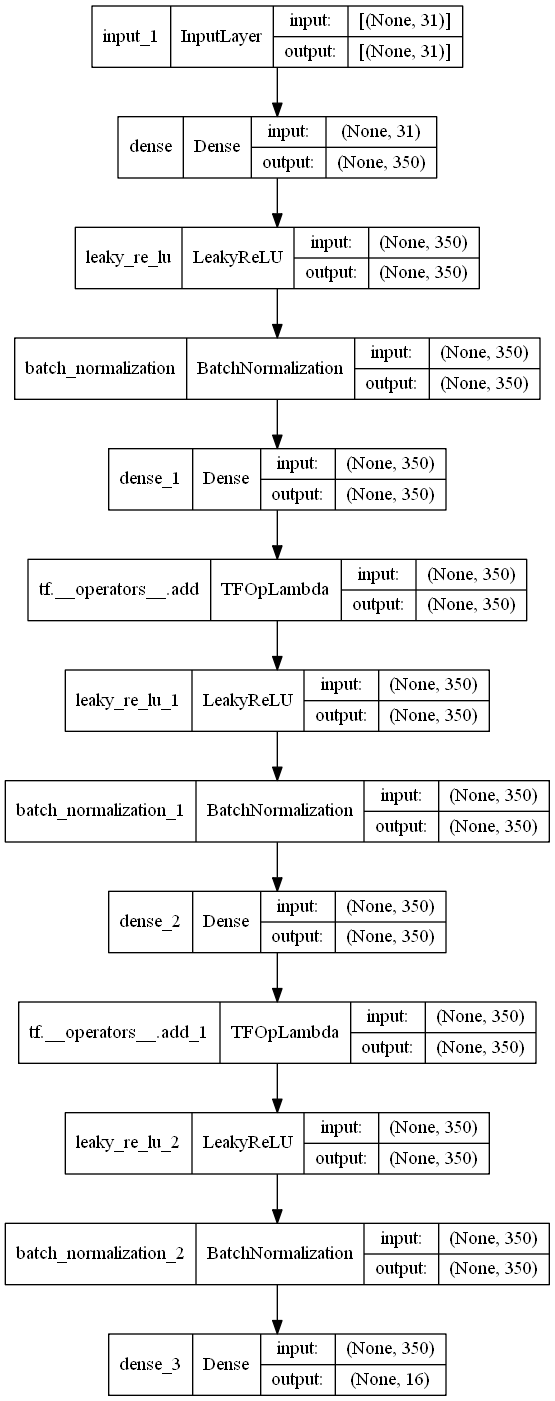

In [9]:


# Tensorflow network as one big Russian doll
inputs = keras.Input(shape=(sum(input_dim_vec),))
input = layers.Dense(width)(inputs)

for i in range(depth-1):
    
    x = layers.LeakyReLU()(input)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(width, kernel_initializer=tf.keras.initializers.Zeros())(x)
    
    # Skip connection 
    x = x + input
    
    input = x

# Final layers
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(latent_dim*2,kernel_initializer=tf.keras.initializers.Zeros())(x)

recognition = keras.Model(inputs=inputs, outputs=outputs, name="encoder_model")

# encoder.summary()

# keras.utils.plot_model(encoder, "encoder.png")
keras.utils.plot_model(recognition, "recognition.png", show_shapes=True)

## Prior network (Encoder)

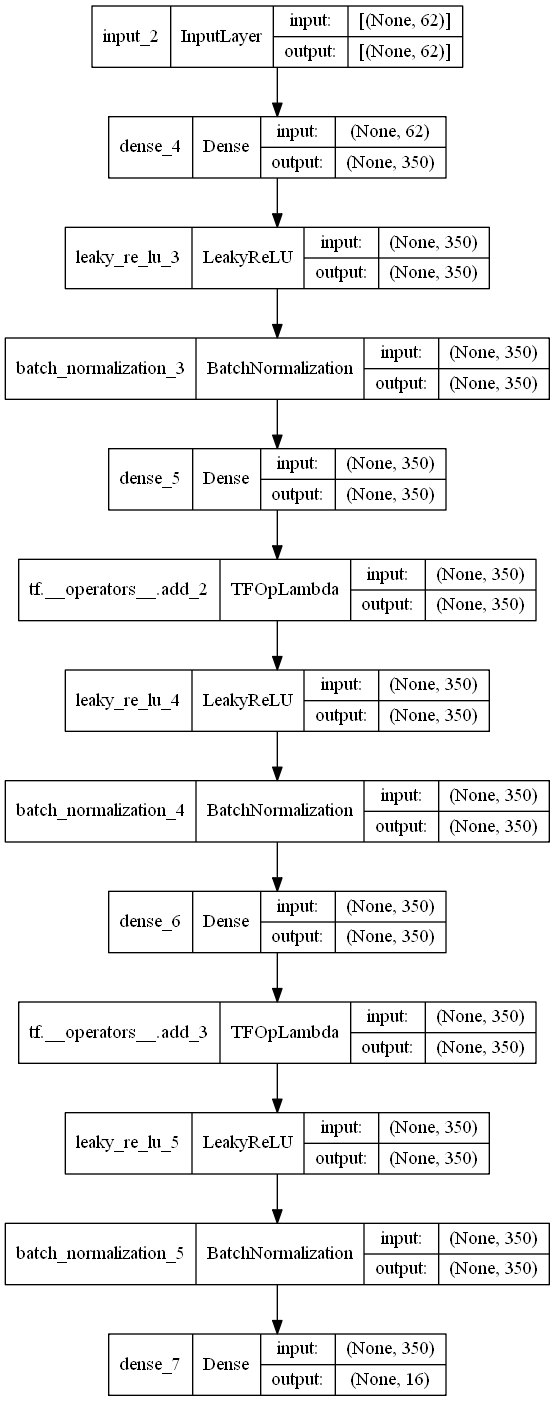

In [10]:
inputs = keras.Input(shape=(sum(input_dim_vec)*2,))
input = layers.Dense(width)(inputs)

for i in range(depth-1):
    
    x = layers.LeakyReLU()(input)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(width, kernel_initializer=tf.keras.initializers.Zeros())(x)
    
    x = x + input
    
    input = x

x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(latent_dim*2,kernel_initializer=tf.keras.initializers.Zeros())(x)

prior = keras.Model(inputs=inputs, outputs=outputs, name="encoder_model")

# encoder.summary()

# keras.utils.plot_model(encoder, "encoder.png")
keras.utils.plot_model(prior, "prior.png", show_shapes=True)

## Generator (Decoder)

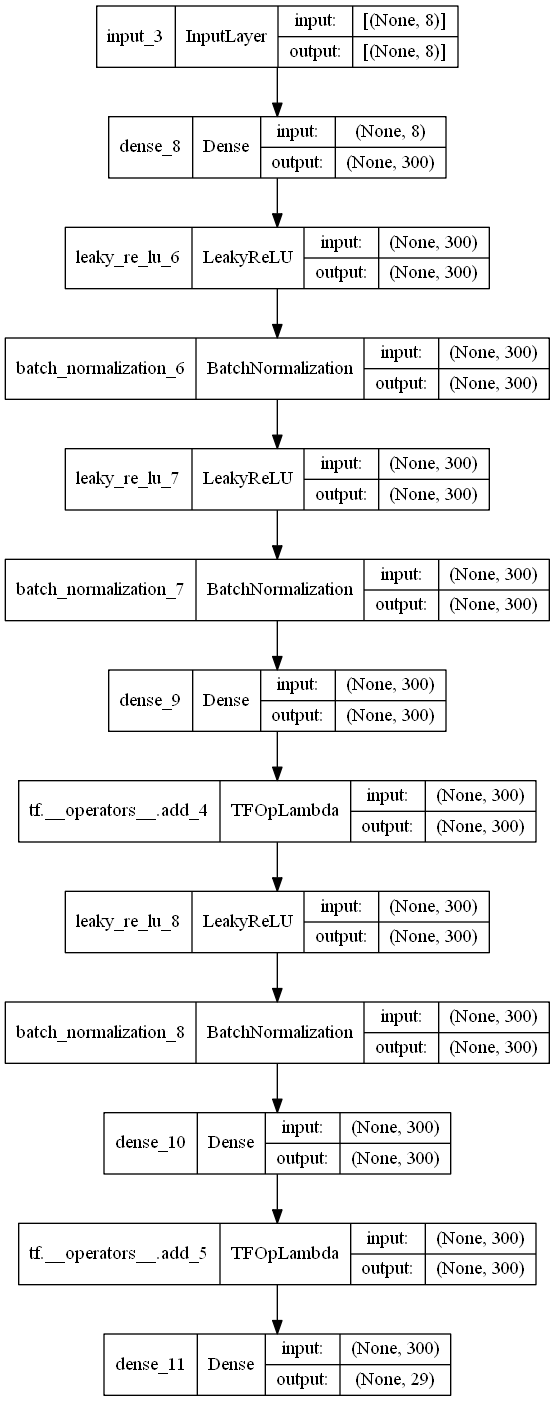

In [13]:
inputs = keras.Input(shape=(latent_dim,))
input = layers.Dense(width,kernel_initializer=tf.keras.initializers.Zeros())(inputs)
input = layers.LeakyReLU()(input)
input = layers.BatchNormalization()(input)

for i in range(depth-1):
    
    x = layers.LeakyReLU()(input)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(width,kernel_initializer=tf.keras.initializers.Zeros())(x)
    
    x = x + input
    
    input = x

outputs = layers.Dense(sum(input_dim_vec),kernel_initializer=tf.keras.initializers.Zeros())(x)

generator = keras.Model(inputs=inputs, outputs=outputs, name="decoder_model")

# decoder.summary()

# keras.utils.plot_model(model, "decoder_model.png")
keras.utils.plot_model(generator, "generator.png", show_shapes=True)

## CLASS VAEAC and loss and training

In [ ]:
class VAEAC_gauss_cat(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.recognition = recognition
        self.prior = prior
        self.generator = generator
        
    @tf.function
    def sample(self, eps=None):
        
        
        
    def recognition_encode(self, x):
        
    
    
    def prior_encode(self, x, mask):
        
    
    
    def decode(self, z_sample):
        
    
    
    def reparameterize(self, mean, logvar)
        
    
    
    def generate_mask
    
    
    
    def compute_loss
    
    
    def train_step

In [ ]:
optimizer = tfa.optimizers.RectifiedAdam(1e-4)

epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 8
num_examples_to_generate = 16

model = VAEAC_gauss_cat(latent_dim)

In [12]:
names = ['wine', 'default_credit', 'compas', 'lsat']
widths = [350, 350, 350, 350] # Bigger than VAE because the task of modelling all conditionals is more complex
depths = [3, 3, 3, 3] # We go deeper because we are using residual models
latent_dims = [6, 8, 4, 4]
under_latent_dims = [6, 8, 4, 4] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]
under_latent_dims2 = [4, 6, 3, 3] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]

dname = 'default_credit'
print(dname)

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../data/')

default_credit


In [ ]:
#Fix input dimensions